## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gymnasium as gym
from diffuser.utils.config import Config, get_params, get_device_settings
from diffuser.utils.training import Trainer
from diffuser.utils.arrays import report_parameters, batchify

import os
import collections
import numpy as np
import pdb
from minari import DataCollector, StepDataCallback
import torch
import sys
import matplotlib.pyplot as plt
import h5py
from datetime import datetime
import wandb

c:\Users\Beste Aydemir\AppData\Local\pypoetry\Cache\virtualenvs\adlr-uQXv-DS1-py3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parse Arguments and Paramters

In [3]:
# Get settings from the config file

parser = get_params()

args = parser.parse_known_args(sys.argv[1:])[0]

# Set Seeds
seed = args.seed
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Get device settings
#device = get_device_settings(args)
device = "cpu"

In [4]:
dataset_config = Config(
    args.loader,
    savepath=(args.savepath, "dataset_config.pkl"),
    env=args.env_name,
    horizon=args.horizon,
    normalizer=args.normalizer,
    preprocess_fns=args.preprocess_fns,
    use_padding=args.use_padding,
    max_path_length=args.max_path_length,
)

render_config = Config(
    args.renderer,
    savepath=(args.savepath, "render_config.pkl"),
    env=args.env_name,
)

model_config = Config(
    args.model,
    savepath=(args.savepath, "model_config.pkl"),
    horizon=args.horizon,
    transition_dim=args.observation_dim + args.action_dim,
    cond_dim=args.observation_dim,
    dim_mults=args.dim_mults,
    device=device,
)
diffusion_config = Config(
    _class="models.diffuser.GaussianDiffusion",
    savepath=(args.savepath, "diffusion_config.pkl"),
    horizon=args.horizon,
    observation_dim=args.observation_dim,
    action_dim=args.action_dim,
    n_timesteps=args.n_timesteps,
    loss_type=args.loss_type,
    clip_denoised=args.clip_denoised,
    predict_epsilon=args.predict_epsilon,
    # loss weighting
    action_weight=args.action_weight,
    loss_weights=args.loss_weights,
    loss_discount=args.loss_discount,
    device=device,
)

trainer_config = Config(
    Trainer,
    savepath=(args.savepath, "trainer_config.pkl"),
    train_batch_size=args.train_batch_size,
    name=args.env_name,
    train_lr=args.train_lr,
    gradient_accumulate_every=args.gradient_accumulate_every,
    ema_decay=args.ema_decay,
    sample_freq=args.sample_freq,
    save_freq=args.save_freq,
    label_freq=args.label_freq,
    save_parallel=args.save_parallel,
    results_folder=args.savepath,
    bucket=args.bucket,
    n_reference=args.n_reference,
    n_samples=args.n_samples,
    device=device,
)

_class:datasets.sequence.GoalDataset
[ utils/config ] Imported diffuser.datasets.sequence:GoalDataset

[utils/config ] Config: <class 'diffuser.datasets.sequence.GoalDataset'>
    env: PointMaze_Medium-v3
    horizon: 256
    max_path_length: 10000
    normalizer: LimitsNormalizer
    preprocess_fns: ['maze2d_set_terminals']
    use_padding: False

[ utils/config ] Saved config to: saved/dataset_config.pkl

_class:utils.rendering.Maze2dRenderer
[ utils/config ] Imported diffuser.utils.rendering:Maze2dRenderer

[utils/config ] Config: <class 'diffuser.utils.rendering.Maze2dRenderer'>
    env: PointMaze_Medium-v3

[ utils/config ] Saved config to: saved/render_config.pkl

_class:models.temporal.TemporalUnet
[ utils/config ] Imported diffuser.models.temporal:TemporalUnet

[utils/config ] Config: <class 'diffuser.models.temporal.TemporalUnet'>
    cond_dim: 4
    dim_mults: (1, 4, 8)
    horizon: 256
    transition_dim: 6

[ utils/config ] Saved config to: saved/model_config.pkl

_class:mo

In [5]:
# Load objects
dataset = dataset_config()
renderer = render_config()
model = model_config()
diffuser = diffusion_config(model)
trainer = trainer_config(diffuser, dataset, renderer,device)

Name of the enviornment: PointMaze_Medium-v3
Name of the enviornment: PointMaze_Medium-v3
Dataset_name:pointmaze-medium-v2
C:\Users\Beste Aydemir\.minari\datasets\pointmaze-medium-v2\data
pointmaze-medium-v2
dataset exists!
[ datasets/buffer ] Finalized replay buffer | 4752 episodes
[ datasets/buffer ] Fields:
    achieved_goal: (4752, 10000, 2)
    desired_goal: (4752, 10000, 2)
    observations: (4752, 10000, 4)
    observation: (4752, 10000, 4)
    next_observations: (4752, 10000, 4)
    actions: (4752, 10000, 2)
    terminals: (4752, 10000, 1)
    timeouts: (4752, 10000, 1)
[ datasets/buffer ] Fields:
    achieved_goal: (4752, 10000, 2)
    desired_goal: (4752, 10000, 2)
    observations: (4752, 10000, 4)
    observation: (4752, 10000, 4)
    next_observations: (4752, 10000, 4)
    actions: (4752, 10000, 2)
    terminals: (4752, 10000, 1)
    timeouts: (4752, 10000, 1)
    normed_observations: (4752, 10000, 4)
    normed_actions: (4752, 10000, 2)
Name of the enviornment: PointMaze_

In [6]:
model_path = "saved/10_ep/state_900000.pt"
trainer.load(directory=model_path, epoch=900000)

Goal used in conditioning:  tensor([[ 1.2565, -0.5560,  0.0000,  0.0000]], dtype=torch.float64)
Starting used in conditioning:  tensor([[ 0.3096, -0.6068,  0.0000,  0.0000]], dtype=torch.float64)
(1, 257, 4)
1
The last observation [ 2.82420254 -1.60068925  0.          0.        ]
Goal in rendering: [ 1.25654418 -0.55602748]
Starting point in rendering: [ 0.30958763 -0.60679074]


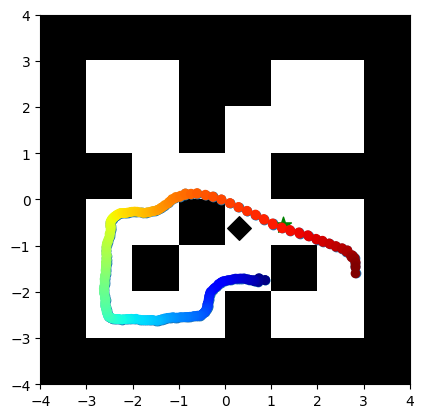

Saved 1 samples to: saved/sample-900000-0.png
Goal used in conditioning:  tensor([[ 1.2565, -0.5560,  0.0000,  0.0000]], dtype=torch.float64)
Starting used in conditioning:  tensor([[ 0.3096, -0.6068,  0.0000,  0.0000]], dtype=torch.float64)
(1, 257, 4)
1
The last observation [ 2.82420254 -1.60068925  0.          0.        ]
Goal in rendering: [ 1.25654418 -0.55602748]
Starting point in rendering: [ 0.30958763 -0.60679074]


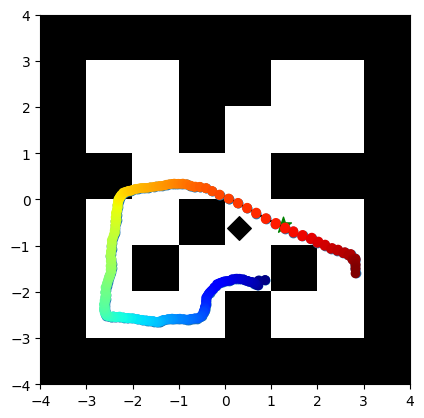

Saved 1 samples to: saved/sample-900000-1.png
Goal used in conditioning:  tensor([[ 1.2565, -0.5560,  0.0000,  0.0000]], dtype=torch.float64)
Starting used in conditioning:  tensor([[ 0.3096, -0.6068,  0.0000,  0.0000]], dtype=torch.float64)


KeyboardInterrupt: 

In [42]:
env = gym.make(args.env_name)
env.reset()
trainer.render_samples_env(env, get_cond_from_env = True, batch_size = 5)

## Forward pass is working

In [ ]:
report_parameters(model)

print("Testing forward...", end=" ", flush=True)
batch = batchify(dataset[0])
loss, _ = diffuser.loss(*batch)
loss.backward()
print("✓")

## Using the trainer requires taking care of the 'device' in the folders

# Training process inlcluding rendering

In [ ]:
current_time = datetime.now().strftime("%d_%m_%Y-%H-%M")

if args.use_wandb:
    run = wandb.init(
        config=args,
        project=args.wandb_project,
        entity=args.wandb_entity,
        name=f"Run_{current_time}",
        group="Group-Name",
        job_type="training",
        reinit=True,
    )

In [ ]:
from tqdm import tqdm
# n_epochs = int(args.n_train_steps // args.n_steps_per_epoch)
n_epochs = 5
diffuser.to(device)
for i in tqdm(range(n_epochs)):
    print(f"Epoch {i} / {n_epochs} | {args.savepath}")
    trainer.train(n_train_steps=10000)

In [ ]:
def extract_datasets(file_path):
    with h5py.File(file_path, "r") as f:
        # Extract observations dataset
        observations = np.array(f["observations"])

        # Extract infos/qpos dataset
        qpos = np.array(f["infos/qpos"])

    return observations, qpos


# Replace 'your_file_path_here' with the actual path to the HDF5 file
file_path = "/Users/magic-rabbit/Downloads/maze2d-large-dense-v1.hdf5"
observations, qpos = extract_datasets(file_path)

# Printing shapes of the arrays to confirm extraction
print("Observations shape:", observations.shape)
print("Qpos shape:", qpos.shape)

LARGE_MAZE = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
    [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1],
    [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
    [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1],
    [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
]
background_array = np.array(LARGE_MAZE)

# Define the extent to center the plot at (0, 0)

plt.clf()
fig = plt.gcf()

plt.imshow(
    background_array,
    cmap=plt.cm.binary,
    # vmin=0,
    # vmax=1,
)

path_length = len(observations)
# observations = observations.reshape(len(observations), -1)
colors = plt.cm.jet(np.linspace(0, 1, 100000))
plt.plot(observations[:100000, 1], observations[:100000, 0], c="black", zorder=10)
plt.scatter(observations[:100000, 1], observations[:100000, 0], c=colors, zorder=20)

In [ ]:
# Medium

# Replace 'your_file_path_here' with the actual path to the HDF5 file
file_path = "/Users/magic-rabbit/Downloads/maze2d-medium-dense-v1.hdf5"
observations, qpos = extract_datasets(file_path)

# Printing shapes of the arrays to confirm extraction
print("Observations shape:", observations.shape)
print("Qpos shape:", qpos.shape)

MEDIUM_MAZE = [
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 1, 1, 0, 0, 1],
    [1, 0, 0, 1, 0, 0, 0, 1],
    [1, 1, 0, 0, 0, 1, 1, 1],
    [1, 0, 0, 1, 0, 0, 0, 1],
    [1, 0, 1, 0, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1],
]
background_array = np.array(MEDIUM_MAZE)


plt.clf()
fig = plt.gcf()

plt.imshow(
    background_array,
    cmap=plt.cm.binary,
    # vmin=0,
    # vmax=1,
)

path_length = len(observations)
# observations = observations.reshape(len(observations), -1)
colors = plt.cm.jet(np.linspace(0, 1, 100000))
plt.plot(observations[:100000, 1], observations[:100000, 0], c="black", zorder=10)
plt.scatter(observations[:100000, 1], observations[:100000, 0], c=colors, zorder=20)